# Non collinear calculations

## Packages

In [1]:
from quantumsparse.spin import SpinOperators
from quantumsparse.operator import Symmetry, Operator
from quantumsparse.spin.shift import shift
from quantumsparse.spin.interactions import Heisenberg, Dzyaloshinskii_Moriya, biquadratic_Heisenberg
from quantumsparse.spin.functions import rotate_spins, get_unitary_rotation_matrix
from quantumsparse.tools.mathematics import product, roots_of_unity
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('../../notebook.mplstyle')                # use matplotlib style notebook.mplstyle

DEBUG = False
TOLERANCE = 1e-10
NEED_EIGENVECTORS = True

## Parameters

Let's define the main parameters of the system: the spin value `S` and the number of sites `Nsites`.

In [ ]:
name = "Cr8"
xc = "LDA+U"
all_Js = {
    "Cr8" : {
        "LDA+U"   : [0.596,0.596,0.843], # meV
        "LDA+U+V" : [0.848,0.848,1.198], # eV
    },
    "V8"  : {
        "LDA+U"   : [-0.643,-0.654,-0.913], # meV
        "LDA+U+V" : [-0.403,-0.403,-0.585], # meV
    }
}

all_bi = {
    "Cr8" : {
        "LDA+U"   : [-0.009,0.005,0.026], # meV
        "LDA+U+V" : None
        
    },
    "V8"  : {
        "LDA+U"   : [-0.23,-0.208,0.091], # meV
        "LDA+U+V" : None
    }
}

all_DM = {
    "Cr8" : {
        "LDA+U"   : [-0.193,-0.193,0.608], # meV
        "LDA+U+V" : [-0.282,-0.282,0.853], # meV
        
    },
    "V8"  : {
        "LDA+U"   : [-0.060,-0.050,-1.049], # meV
        "LDA+U+V" : [-0.175,-0.170,-0.813], # meV
    }
}

S     = 3./2 # spin value
Nsites = 4 # number of sites
spin_values = np.full(Nsites,S)

def build_H(Sx,Sy,Sz):
    Js = all_Js[name][xc]
    BI = all_bi[name][xc]
    DM = all_DM[name][xc]
    h =     Heisenberg(Sx,Sy,Sz,Js)
    h = h + biquadratic_Heisenberg(Sx,Sy,Sz,BI)
    h = h + Dzyaloshinskii_Moriya(Sx,Sy,Sz,DM)
    return h.clean()

## Spin operators

From these values we can construct the spin operators `Sx`, `Sy`, and `Sz` of the system (in cartesian coordinates).

In [3]:
# construct the spin operators
SpinOp = SpinOperators(spin_values)

# unpack the operators
spins = SpinOp.Sx,SpinOp.Sy,SpinOp.Sz
Sx,Sy,Sz = spins

In [4]:
# let's show the Hilbert space basis:
# each row is a basis state
# each column if one component in the Sz-basis
SpinOp.basis

,0,1,2,3
0,1.5,1.5,1.5,1.5
1,1.5,1.5,1.5,0.5
2,1.5,1.5,1.5,-0.5
3,1.5,1.5,1.5,-1.5
4,1.5,1.5,0.5,1.5
...,...,...,...,...
251,-1.5,-1.5,-0.5,-1.5
252,-1.5,-1.5,-1.5,1.5
253,-1.5,-1.5,-1.5,0.5
254,-1.5,-1.5,-1.5,-0.5


Pay attention that `Sx` (as well as `Sy`, and `Sz`) are `numpy.array` with lenght `Nsites`, and each one of its element is a `Operator` object.

Let's inspect one element.

In [5]:
assert isinstance(Sx[0],Operator), "Sx[0] should be an Operator instance"
Sx[0]

          name: None
  memory (csr): 2032 bytes
 memory (deep): 7313 bytes
          type: float64
         shape: (256, 256)
      sparsity: 0.005859
         # all: 384
         #  on: 0
         # off: 384
    norm (all): 17.888544
    norm  (on): 0.000000
    norm (off): 17.888544
     hermitean: True
     symmetric: True
       unitary: False
     n. blocks: unknown
   eigenvalues: computed
   eigenstates: computed

## Hamiltonian

Let's construct the Hamiltonian.

In [6]:
# cylindricar coordinates
H = build_H(Sx,Sy,Sz)
H

          name: None
  memory (csr): 2032 bytes
 memory (deep): 2981 bytes
          type: complex128
         shape: (256, 256)
      sparsity: 0.037354
         # all: 2448
         #  on: 144
         # off: 2304
    norm (all): 60.786906
    norm  (on): 33.720000
    norm (off): 50.576769
     hermitean: True
     symmetric: False
       unitary: False
     n. blocks: unknown
   eigenvalues: unknown
   eigenstates: unknown

## Translational symmetry

Let's construct the shift operator (or traslation operator) because it will be usefull later on to make the diagonalization of the Hamiltoninan cheaper.

In [7]:
if os.path.exists(f"D.S={S}.N={Nsites}.pickle"):
    D = Symmetry.load(f"D.S={S}.N={Nsites}.pickle") # load the symmetry operator from a file
else:
    D:Symmetry = shift(SpinOp)
D

          name: None
  memory (csr): 1004 bytes
 memory (deep): 3515 bytes
          type: float64
         shape: (256, 256)
      sparsity: 0.003906
         # all: 256
         #  on: 4
         # off: 252
    norm (all): 16.000000
    norm  (on): 2.000000
    norm (off): 15.874508
     hermitean: False
     symmetric: False
       unitary: True
     n. blocks: 70
   eigenvalues: computed
   eigenstates: computed

Let's diagonalize the shift operator so that we have access to its eigenvectors.

In [8]:
if not D.is_diagonalized():
    D.diagonalize(method="dense") # 'dense' is much better than 'jacobi'
    
if DEBUG:
    test = D.test_eigensolution()
    assert test.norm() < TOLERANCE, f"Symmetry operator D is not diagonalized correctly: {test.norm()}"

D

          name: None
  memory (csr): 1004 bytes
 memory (deep): 3515 bytes
          type: float64
         shape: (256, 256)
      sparsity: 0.003906
         # all: 256
         #  on: 4
         # off: 252
    norm (all): 16.000000
    norm  (on): 2.000000
    norm (off): 15.874508
     hermitean: False
     symmetric: False
       unitary: True
     n. blocks: 70
   eigenvalues: computed
   eigenstates: computed

In [9]:
if DEBUG :
    
    test = D.test_eigensolution()
    norm  = test.norm()
    assert norm < TOLERANCE, f"Symmetry operator D is not diagonalized correctly: {norm}"

    # the number of energy levels should be equal to the number of sites
    l,N = D.energy_levels()
    # print(len(l))
    assert len(l) == Nsites, "wrong number of energy levels"

    # the eigenvalues should be the roots of unity
    ru = np.sort(roots_of_unity(len(spin_values)))
    l  = np.sort(l)    
    assert np.allclose(l,ru), "The eigenvalues should be the roots of the unity."


# test

Let' save the shift operator, and its eigensolutions to file.

In [10]:
D.save(f"D.S={S}.N={Nsites}.pickle") # save the symmetry operator to a file

## Diagonalizing the Hamiltonian

In [11]:
if DEBUG:
    comm = Operator.commutator(H,D)
    assert comm.norm() < TOLERANCE, "Commutator is not zero, the symmetry operator does not commute with the Hamiltonian"

if not H.is_diagonalized(): 
    H.diagonalize_with_symmetry(S=[D],method="dense"); # diagonalize the Hamiltonian
    
if DEBUG:
    test = H.test_eigensolution()
    norm = test.norm()
    assert norm < TOLERANCE, f"Hamiltonian is not diagonalized correctly: {norm}"
    
H

Diagonalizing blocks: 100%|██████████| 6/6 [00:00<00:00, 467.04block/s]


          name: None
  memory (csr): 2032 bytes
 memory (deep): 9527 bytes
          type: complex128
         shape: (256, 256)
      sparsity: 0.037354
         # all: 2448
         #  on: 144
         # off: 2304
    norm (all): 60.786906
    norm  (on): 33.720000
    norm (off): 50.576769
     hermitean: True
     symmetric: False
       unitary: False
     n. blocks: unknown
   eigenvalues: computed
   eigenstates: computed

In [12]:
H.save(f"H.{name}.xc={xc}.pickle") # save the Hamiltonian to a file

## Cylindrical coordinates

In [13]:
EulerAngles = np.zeros((Nsites,3))
EulerAngles[:,2] = np.linspace(0,360,Nsites,endpoint=False)
EulerAngles = np.pi * EulerAngles / 180
print("Euler angles (in radians):\n", EulerAngles)

Euler angles (in radians):
 [[0.         0.         0.        ]
 [0.         0.         1.57079633]
 [0.         0.         3.14159265]
 [0.         0.         4.71238898]]


In [14]:
StR,SrR,SzR= rotate_spins(spins,EulerAngles=EulerAngles,method="R")
if NEED_EIGENVECTORS:
    U, Ud = get_unitary_rotation_matrix(spins, EulerAngles)
    Utot = product(U).clean() # this is really memory intensive
Utot

  memory (csr): 2032 bytes
 memory (deep): 2928 bytes
          type: complex128
         shape: (256, 256)
      sparsity: 0.003906
         # all: 256
         #  on: 256
         # off: 0
    norm (all): 16.000000
    norm  (on): 16.000000
    norm (off): 0.000000
     hermitean: False
     symmetric: True
       unitary: True
     n. blocks: unknown
   eigenvalues: unknown
   eigenstates: unknown

In [15]:
if DEBUG and NEED_EIGENVECTORS:
    StR,SrR,SzR= rotate_spins(spins,EulerAngles=EulerAngles,method="R")
    StU,SrU,SzU= rotate_spins(spins,EulerAngles=EulerAngles,method="U")
    for n in range(Nsites):
        print(f"Site {n}:")
        assert (StR[n] - StU[n]).norm() < TOLERANCE, "St rotation mismatch"
        assert (SrR[n] - SrU[n]).norm() < TOLERANCE, "Sr rotation mismatch"
        assert (SzR[n] - SzU[n]).norm() < TOLERANCE, "Sz rotation mismatch"

    Utot = product(U).clean()
    UdTot = product(Ud).clean()
    assert (Utot - UdTot.dagger()).norm() < TOLERANCE, "Utot and UdTot mismatch"

    for n in range(Nsites):
        print(f"Site {n}:") 
        assert (StR[n] - Utot @ Sx[n] @ UdTot).norm() < TOLERANCE, "St rotation mismatch"
        assert (SrR[n] - Utot @ Sy[n] @ UdTot).norm() < TOLERANCE, "Sr rotation mismatch"
        assert (SzR[n] - Utot @ Sz[n] @ UdTot).norm() < TOLERANCE, "Sz rotation mismatch"

In [16]:
Hcyl = build_H(StR,SrR,SzR)
Hcyl

          name: None
  memory (csr): 2032 bytes
 memory (deep): 2981 bytes
          type: complex128
         shape: (256, 256)
      sparsity: 0.037354
         # all: 2448
         #  on: 144
         # off: 2304
    norm (all): 60.786906
    norm  (on): 33.720000
    norm (off): 50.576769
     hermitean: True
     symmetric: False
       unitary: False
     n. blocks: unknown
   eigenvalues: unknown
   eigenstates: unknown

In [17]:
print("n of blocks of H   : ", H.count_blocks()[0])
print("n of blocks of Hcyl: ", Hcyl.count_blocks()[0])

n of blocks of H   :  3
n of blocks of Hcyl:  3


In [18]:
if DEBUG:
    Htest = H.unitary_transformation(Utot)
    test = Hcyl - Htest
    norm = test.norm()
    assert norm < TOLERANCE, f"Hamiltonian in cylindrical coordinates is not correct: {norm}"
    Htest

In [19]:
Hfinal = H.unitary_transformation(Utot) # from cartesian to cylindrical frame
if DEBUG:
    test = Hfinal.test_eigensolution()
    norm = test.norm()
    assert norm < TOLERANCE, f"Hamiltonian in cylindrical coordinates is not correct: {norm}"
Hfinal

          name: None
  memory (csr): 2032 bytes
 memory (deep): 9361 bytes
          type: complex128
         shape: (256, 256)
      sparsity: 0.037354
         # all: 2448
         #  on: 144
         # off: 2304
    norm (all): 60.786906
    norm  (on): 33.720000
    norm (off): 50.576769
     hermitean: True
     symmetric: False
       unitary: False
     n. blocks: unknown
   eigenvalues: computed
   eigenstates: computed

In [20]:
H = Hfinal

## Density of states

In [21]:
l, N = H.energy_levels() # return the energy levels of the Hamiltonian
assert N.sum() == H.shape[0], "The sum of the energy level weights should be equal to the number of sites"
print(f"Found {len(l)} energy levels")

Found 194 energy levels


/home/stoccoel/programs/miniforge/envs/qs/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stoccoel/programs/miniforge/envs/qs/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


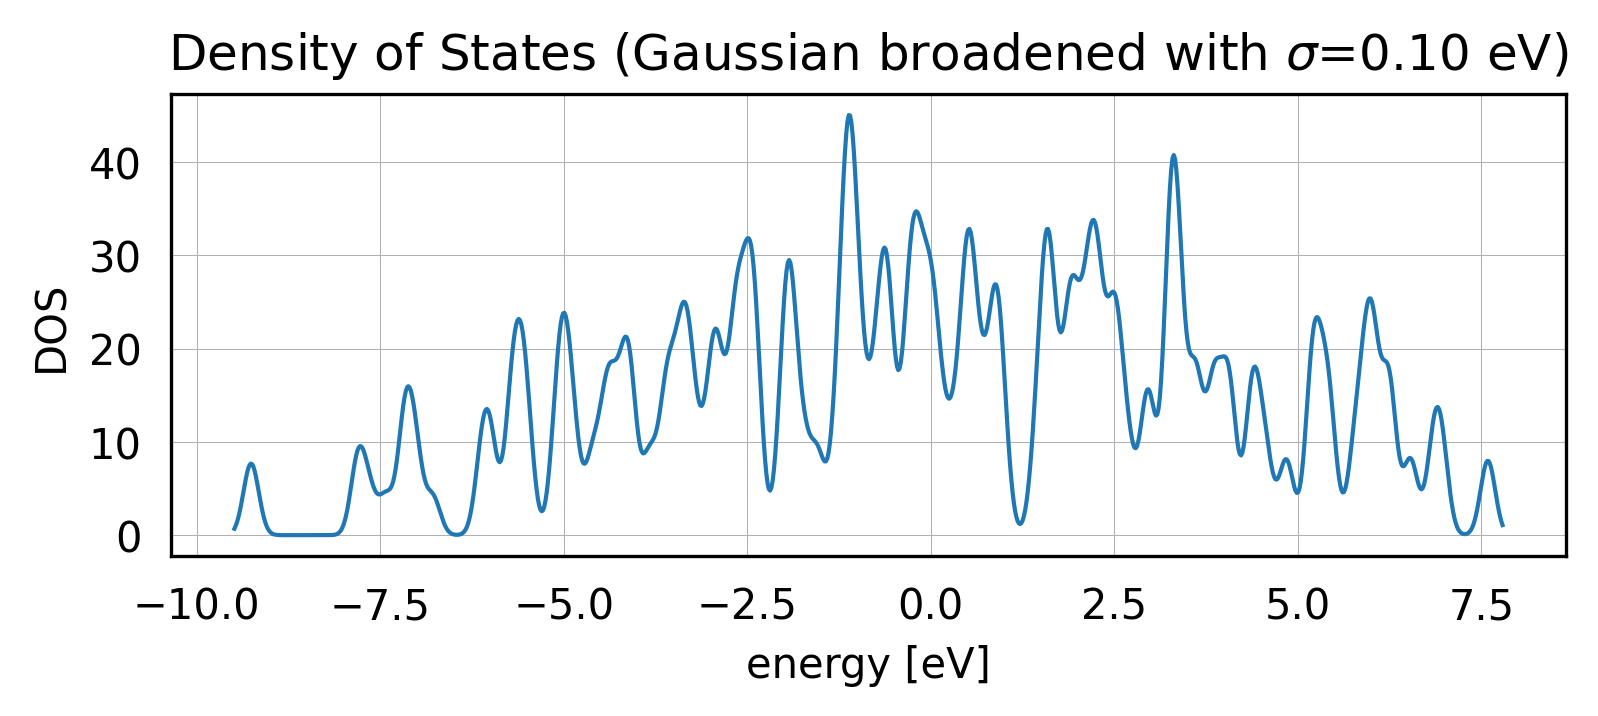

<Figure size 1800x600 with 0 Axes>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Example: assume l and N are already defined
# l: array of energy levels
# N: degeneracies (or set to 1 if not available)

# If N not given, use uniform weights:
# N = np.ones_like(l)

# Parameters
sigma = 0.1  # Width of Gaussian
E_min, E_max = l.min() - 2*sigma, l.max() + 2*sigma
E_vals = np.linspace(E_min, E_max, 1000)

# Initialize DOS array
dos = np.zeros_like(E_vals)

# Manually compute Gaussian for each energy level
prefactor = 1 / (sigma * np.sqrt(2 * np.pi))
for energy, weight in zip(l, N):
    gaussian = weight * prefactor * np.exp(-0.5 * ((E_vals - energy) / sigma)**2)
    dos += gaussian

# Plotting
plt.plot(E_vals, dos)
plt.xlabel('energy [eV]')
plt.ylabel('DOS')
plt.title(r'Density of States (Gaussian broadened with $\sigma$={:.2f} eV)'.format(sigma))
plt.grid(True)
# plt.xlim(-20,20)
# plt.legend()
plt.show()
plt.savefig(f"{name}.xc={xc}.pdf", bbox_inches='tight')
